# Infer ***lysosome*** -  4️⃣

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component ***lyso***  in order to understand interactome 

Infer the shape of the lysosomes in order to measure their extent, shape, position, and size.

Dependencies:
The ***lysosome***  inference rely on the ***cytoplasm*** mask.


## preamble

1. imports
2. setup
3. infer nuclei mask
4. infer cellmask mask
5. infer cytoplasm mask
6. infer lysosomes
    * pre-processing
    * core processing
    * post processing


## IMPORTS

In [2]:
# top level imports
from pathlib import Path
import os, sys
from typing import Optional

import numpy as np

from aicssegmentation.core.seg_dot import (dot_2d_slice_by_slice_wrapper,
                                           dot_3d_wrapper)
from aicssegmentation.core.pre_processing_utils import (intensity_normalization, image_smoothing_gaussian_slice_by_slice)
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import (filament_2d_wrapper,
                                          filament_3d_wrapper)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                                                    list_image_files)
from infer_subc.core.img import *

from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )          

from infer_subc.organelles import fixed_infer_cellmask_fromaggr, fixed_infer_nuclei, infer_cytoplasm, find_optimal_Z

%load_ext autoreload
%autoreload 2

# additional imports for nuc/cellmask/cytoplasm
from collections import defaultdict
from scipy import ndimage as ndi
from aicssegmentation.core.MO_threshold import MO
from skimage import filters
from skimage.segmentation import watershed
from skimage.morphology import (binary_erosion,
                                remove_small_holes)
from skimage.measure import label

## SETUP
CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/infer-subc"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\Anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## INFER NUCLEI MASK

Using function defined in 01_infer_nuclei_3D.ipynb

In [5]:
def _infer_nuclei_3D( in_img: np.ndarray,
                       median_sz: int, 
                       gauss_sig: float,
                       thresh_factor: float,
                       thresh_min: float,
                       thresh_max: float,
                       max_hole_w: int,
                       small_obj_w: int,
                       sz_filter_method: str
                     ) -> np.ndarray:
    """
    Procedure to infer 3D nuclei segmentation from multichannel z-stack input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: Optional[np.ndarray] = None
        mask
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimum object size cutoff for nuclei post-processing
    sz_filter_method: str
        method for size filtering; either "3D" or "slice_by_slice"

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    ###################
    # INPUT
    ################### 
    nuc_ch = NUC_CH
    nuclei = select_channel_from_raw(in_img, nuc_ch)


    ###################
    # PRE_PROCESSING
    ###################                
    nuclei = min_max_intensity_normalization(nuclei)
    nuclei = median_filter_slice_by_slice(nuclei,
                                          size=median_sz)
    nuclei = image_smoothing_gaussian_slice_by_slice(nuclei,
                                                     sigma=gauss_sig )


    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                           thresh_factor=thresh_factor, 
                                           thresh_min=thresh_min, 
                                           thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = hole_filling(nuclei_object, 
                                 hole_min=0, 
                                 hole_max=max_hole_w**2, 
                                 fill_2d=True)

    nuclei_object = size_filter(nuclei_object, 
                                min_size = small_obj_w**3, 
                                method = sz_filter_method,
                                connectivity=1)


    return nuclei_object


def _fixed_infer_nuclei_3D(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: np.ndarray
        mask
 
    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    nuc_ch = NUC_CH
    median_sz = 4   
    gauss_sig = 1.34
    threshold_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.0
    max_hole_w = 5
    small_obj_w = 15
    sz_filter_method = "3D"

    return _infer_nuclei_3D( in_img,
                             median_sz,
                             gauss_sig,
                             threshold_factor,
                             thresh_min,
                             thresh_max,
                             max_hole_w,
                             small_obj_w,
                             sz_filter_method )


_NU_object =  _fixed_infer_nuclei_3D(img_data) 
NU_labels = label(_NU_object)

## GET CELLMASK

Using function defined in 02_infer_cellmask_fromaggr_3D.ipynb

In [6]:
def _raw_soma_MCZ(img_in):
    """ define cellmask image
    """
    SOMA_W = (6.,1.,2.)
    SOMA_CH = (LYSO_CH,ER_CH,GOLGI_CH)
    img_out = np.zeros_like(img_in[0]).astype(np.double)
    for w,ch in zip(SOMA_W,SOMA_CH):
        img_out += w*img_in[ch]
    return img_out


def _non_linear_soma_transform_MCZ(in_img):
    """ non-linear distortion to fill out cellmask
    log + edge of smoothed composite
    """
    # non-Linear processing
    log_img, d = log_transform(in_img.copy()) 
    return intensity_normalization(log_img,scaling_param=[0])


def _masked_object_thresh(
    structure_img_smooth: np.ndarray, th_method: str, cutoff_size: int, th_adjust: float
) -> np.ndarray:
    """
    wrapper for applying Masked Object Thresholding with just two parameters via `MO` from `aicssegmentation`
    Parameters
    ------------
    structure_img_smooth: np.ndarray
        a 3d image
    th_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    cutoff_size: 
        Masked Object threshold `size_min`
    th_adjust: 
        Masked Object threshold `local_adjust`

    Returns
    -------------
        np.ndimage 

    """

    struct_obj = MO(
        structure_img_smooth,
        global_thresh_method=th_method,
        object_minArea=cutoff_size,
        extra_criteria=True,
        local_adjust=th_adjust,
        return_object=False,
        dilate=True,
    )
    return struct_obj


def _masked_inverted_watershed(img_in, markers, mask):
    """wrapper for watershed on inverted image and masked

    """
    labels_out = watershed(
                1. - img_in,
                markers=markers,
                connectivity=3,
                mask=mask,
                )
    return labels_out


def _choose_max_label(raw_signal: np.ndarray, labels_in: np.ndarray):
    """ keep only the label with the maximum raw signal

    """

    all_labels = np.unique(labels_in)[1:]

    total_signal = [raw_signal[labels_in == label].sum() for label in all_labels]
    # combine NU and "labels" to make a SOMA
    keep_label = all_labels[np.argmax(total_signal)]

    labels_max = np.zeros_like(labels_in)
    labels_max[labels_in==keep_label] = 1
    return labels_max

In [7]:
def _infer_cellmask_fromaggr_3D(in_img: np.ndarray,
    nuclei_labels: np.ndarray,
    median_sz_soma: int,
    gauss_sig_soma: float,
    gauss_truc_rang: float,
    mo_method: str,
    mo_adjust: float,
    mo_cutoff_size: int,
    max_hole_w_soma: int,
    small_obj_w_soma: int
) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_labels:
        a 3d mask of nuclei
    median_sz_soma: 
        width of median filter for _soma_ signal
    gauss_sig_soma: 
        sigma for gaussian smoothing of _soma_ signal
    gauss_truc_rang:
        cutoff value for gaussian
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w_soma: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w_soma: 
        minimu object size cutoff for cellmask signal post-processing

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of cellmask

    """

    ###################
    # EXTRACT
    ###################
    struct_img = _raw_soma_MCZ(in_img)


    ###################
    # PRE_PROCESSING
    ###################                         
    ################# part 1- cellmask
    struct_img = min_max_intensity_normalization(struct_img)

    # make a copy for post-post processing
    scaled_signal = struct_img.copy()

    # Linear-ish processing
    struct_img = median_filter_slice_by_slice(struct_img, 
                                              size=median_sz_soma)

    struct_img = ndi.gaussian_filter(struct_img,
                                     sigma=gauss_sig_soma,
                                     mode="nearest",
                                     truncate=gauss_truc_rang)

    struct_img_non_lin = _non_linear_soma_transform_MCZ(struct_img)
   

    ###################
    # CORE_PROCESSING
    ###################    
    struct_obj = _masked_object_thresh(struct_img_non_lin, 
                                       th_method=mo_method, 
                                       cutoff_size=mo_cutoff_size, 
                                       th_adjust=mo_adjust)               


    ###################
    # POST_PROCESSING
    ###################
    struct_obj = hole_filling(struct_obj, 
                              hole_min =0 , 
                              hole_max=max_hole_w_soma**2, 
                              fill_2d = True) 

    struct_obj = size_filter_linear_size(struct_obj, 
                                min_size= small_obj_w_soma**3, 
                                connectivity=1)

    labels_out = _masked_inverted_watershed(struct_obj, nuclei_labels, struct_obj)


    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    soma_out = _choose_max_label(struct_img, labels_out)

    return soma_out


def _fixed_infer_cellmask_fromaggr_3D(in_img: np.ndarray, nuclei_labels: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_object:
        a 3d mask of nuclei

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of cellmask
    """
    
    ###################
    # PARAMETERS
    ###################   
    median_sz_soma = 15
    gauss_sig_soma = 1.34
    gauss_truc_rang = 3.0
    mo_method = "ave"
    mo_adjust = 0.15
    mo_cutoff_size = 50
    max_hole_w_soma = 100
    small_obj_w_soma = 45

    soma_out = _infer_cellmask_fromaggr_3D(in_img,
                              nuclei_labels,
                              median_sz_soma,
                              gauss_sig_soma,
                              gauss_truc_rang,
                              mo_method,
                              mo_adjust,
                              mo_cutoff_size,
                              max_hole_w_soma,
                              small_obj_w_soma) 

    return soma_out


SO_label =  _fixed_infer_cellmask_fromaggr_3D(img_data, NU_labels) 

intensity normalization: min-max normalization with NO absoluteintensity upper bound


## GET CYTOSOL MASK


In [8]:
#selecting single nuclei that matches the single cytoplasm selected above
NU_object = np.logical_and(SO_label,NU_labels)

In [9]:
def _infer_cytoplasm(soma_mask, nuclei_object, erode_nuclei = True):
    """
    Procedure to infer cytoplasm from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: 
        a 3d image containing the nuclei signal

    soma_mask: 
        a 3d image containing the cellmask signal

    erode_nuclei: 
        should we erode?

    Returns
    -------------
    cytoplasm_mask 
        boolean np.ndarray
      
    """

    if erode_nuclei:
        cytoplasm_mask = np.logical_and(soma_mask, ~binary_erosion(nuclei_object))
        # cytoplasm_mask = np.logical_xor(soma_mask, binary_erosion(nuclei_object))
    else:
        cytoplasm_mask = np.logical_and(soma_mask, ~nuclei_object)
        # cytoplasm_mask = np.logical_xor(soma_mask, nuclei_object)


    return cytoplasm_mask


cytoplasm_mask = _infer_cytoplasm(SO_label, NU_object) 

In [10]:
viewer = napari.Viewer()

In [13]:
viewer.add_labels(
    NU_labels,
    scale=scale
)
viewer.add_labels(
    NU_object,
    scale=scale
)
viewer.add_labels(
    SO_label,
    scale=scale
)
viewer.add_image(
    cytoplasm_mask,
    scale=scale
)

<Image layer 'cytoplasm_mask' at 0x27a3ddfa910>

---------------------

## infer ***lysosome***

## summary of steps (Workflow #1 & #2)

INPUT
- channel  2
- cytoplasm mask

PRE-PROCESSING
-  smooth / remove noise

CORE-PROCESSING
- enhance two classes of "spots"
-  segment objects

POST-PROCESSING
  - filter objects

OUTPUT
- object ***lysosome*** 


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> Using Allen Cell Segmenter LAMP1 [workflow](https://www.allencell.org/cell-observations/category/lamp1).  Examples sourced from: [Notebook](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/lookup_table_demo/playground_lamp1.ipynb) and [script](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/aicssegmentation/structure_wrapper/seg_lamp1.py)



## INPUT prototype

In [11]:

###################
# INPUT
###################
raw_lyso = select_channel_from_raw(img_data, LYSO_CH)


In [12]:
viewer.add_image(
    raw_lyso,
    scale=scale
)

<Image layer 'raw_lyso' at 0x27433ca9ca0>

## PRE-PROCESSING prototype


In [13]:
###################
# PRE_PROCESSING
###################

# Linear-ish smoothing
lyso = min_max_intensity_normalization(raw_lyso)

med_filter_size = 3   
lyso_med = median_filter_slice_by_slice(lyso, 
                                            size=med_filter_size)

gaussian_smoothing_sigma = 1.34
gaussian_smoothing_truncate_range = 3.0
lyso_gaus = image_smoothing_gaussian_slice_by_slice(lyso_med,
                                                        sigma=gaussian_smoothing_sigma,
                                                        truncate_range = gaussian_smoothing_truncate_range )

struct_img = lyso_gaus

In [14]:
viewer.add_image(
    lyso,
    scale=scale
)
viewer.add_image(
    lyso_med,
    scale=scale
)
viewer.add_image(
    lyso_gaus,
    scale=scale
)

<Image layer 'lyso_gaus' at 0x2742bd75940>

## CORE PROCESSING prototype

In [58]:
###################
# CORE_PROCESSING
###################
# dot and filiment enhancement - 3D

################################
## PARAMETERS for this step ##
s3_param = [[5,0.1], [2.5,.07], [0.5,0.05]]
################################
bw_spot_3D = dot_3d_wrapper(struct_img, s3_param)


################################
## PARAMETERS for this step ##
f3_param = [[2, 0.03]]
################################
bw_filament_3D = filament_3d_wrapper(struct_img, f3_param)

bw = np.logical_or(bw_spot_3D, bw_filament_3D)

In [60]:
viewer.add_image(
    bw_spot_3D,
    scale=scale,
    opacity=0.2
)
viewer.add_image(
    bw_filament_3D,
    scale=scale,
    opacity=0.2
)
viewer.add_image(
    bw,
    scale=scale
)

<Image layer 'bw' at 0x2742c7c0670>

### POST-PROCESSING

> NOTE: we are using the 3D aicssegmentation functions which wrap `scipy.ndimage` functions with a single Z rather than the `scipy.ndimage` functions directly

In [78]:
###################
# POST_PROCESSING
###################

################################
fill_2d = True
fill_max_size = 25
hole_min = 0
removed_holes = hole_filling(bw, hole_min ** 2, fill_max_size ** 2, fill_2d)

masked_img = apply_mask(removed_holes, cytoplasm_mask)

width = 3  
cleaned_img = size_filter(masked_img, 
                          min_size= width**3,
                          method="3D",
                          connectivity=1)

In [77]:
viewer.add_image(
    removed_holes,
    scale=scale
)
viewer.add_image(
    cleaned_img,
    scale=scale
)
viewer.add_image(
    masked_img,
    scale=scale
)

<Image layer 'masked_img [2]' at 0x27454192f70>

>> <code style="background:yellow;color:black">This segmentation is too permisive with the current settings in iPSCs</code>

## DEFINE `_infer_lyso` function

Based on the _prototyping_ above define the function to infer the lysosomes.  



In [84]:
##########################
#  infer_LYSOSOMES
##########################
def _infer_lyso_3D(in_img: np.ndarray,
                    cytoplasm_mask: np.ndarray,
                    median_sz: int,
                    gauss_sig: float,
                    dot_scale_1: float,
                    dot_cut_1: float,
                    dot_scale_2: float,
                    dot_cut_2: float,
                    dot_scale_3: float,
                    dot_cut_3: float,
                    filament_scale : float,
                    filament_cut : float,
                    min_hole_w: int,
                    max_hole_w: int,
                    small_obj_w: int,
                        ) -> np.ndarray:
    """
    Procedure to infer lyso from linearly unmixed input,
    
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cytoplasm_mask: 
        mask
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    min_hole_w: 
        hole filling min for nuclei post-processing
    max_hole_w: 
        hole filling cutoff for nuclei post-processing
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    lyso_object
        mask defined extent of lyso object

    """
    lyso_ch = LYSO_CH
    ###################
    # INPUT
    ###################    
    lyso = select_channel_from_raw(in_img, lyso_ch)

     ###################
    # PRE_PROCESSING
    ###################    
    lyso = min_max_intensity_normalization(lyso)

    lyso = median_filter_slice_by_slice(lyso, size=median_sz)

    lyso = image_smoothing_gaussian_slice_by_slice(lyso, sigma=gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    s3_param = [    
                [dot_scale_1, dot_cut_1],
                [dot_scale_2, dot_cut_2],
                [dot_scale_3, dot_cut_3]
                ]
    bw_spot = dot_3d_wrapper(lyso, s3_param)

    f3_param = [[filament_scale, filament_cut]]
    bw_filament = filament_3d_wrapper(lyso, f3_param)

    bw = np.logical_or(bw_spot, bw_filament)

    ###################
    # POST_PROCESSING
    ###################

    struct_obj = hole_filling(bw, hole_min = min_hole_w ** 2, hole_max=max_hole_w ** 2, fill_2d = True) 

    struct_obj = apply_mask(struct_obj, cytoplasm_mask)

    struct_obj = size_filter(struct_obj, 
                            min_size= small_obj_w**3, 
                            method= "3D",
                            connectivity=1)
                
    return struct_obj

In [81]:


##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_lyso_3D(in_img: np.ndarray, 
                                                cytoplasm_mask: Optional[np.ndarray] = None
                                            ) -> np.ndarray:
    """
    Procedure to infer lyso from linearly unmixed input with *fixed parameters*
    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    cytoplasm_mask: Optional[np.ndarray] = None
        mask

    Returns
    -------------
    lyso_object
        mask defined extent of NU
    """
    median_sz = 3
    gauss_sig = 1.34
    dot_scale_1 = 5
    dot_cut_1 = 0.1
    dot_scale_2 = 2.5
    dot_cut_2 = 0.07
    dot_scale_3 = 0.5
    dot_cut_3 = 0.05
    filament_scale = 2
    filament_cut = 0.03
    min_hole_w = 0
    max_hole_w = 25
    small_obj_w = 3

    return _infer_lyso_3D(  in_img,
                                cytoplasm_mask,
                                median_sz,
                                gauss_sig,
                                dot_cut_1,
                                dot_scale_1,
                                dot_cut_2,
                                dot_scale_2,
                                dot_cut_3,
                                dot_scale_3,
                                filament_scale,
                                filament_cut ,
                                min_hole_w,
                                max_hole_w,
                                small_obj_w)


------------------

# TEST `_infer_lyso` function

In [85]:

_lyso_object =  _fixed_infer_lyso_3D(img_data, cytoplasm_mask) 

viewer.add_image(
    _lyso_object,
    scale=scale
)

<Image layer '_lyso_object [1]' at 0x2745308e760>

<code style="background:yellow;color:black">***WIP*** 2D-->3D transition stops here</code>

In [19]:
from infer_subc.organelles.lysosome import fixed_infer_lyso

lyso_object =  fixed_infer_lyso(img_2D, cytoplasm_mask) 



In [20]:

viewer.add_image(
    _lyso_object,
    scale=scale
)
viewer.add_labels(
    label(lyso_object),
    scale=scale
)
viewer.add_image(
    lyso_object,
    scale=scale
)

<Image layer 'lyso_object' at 0x171650f70>

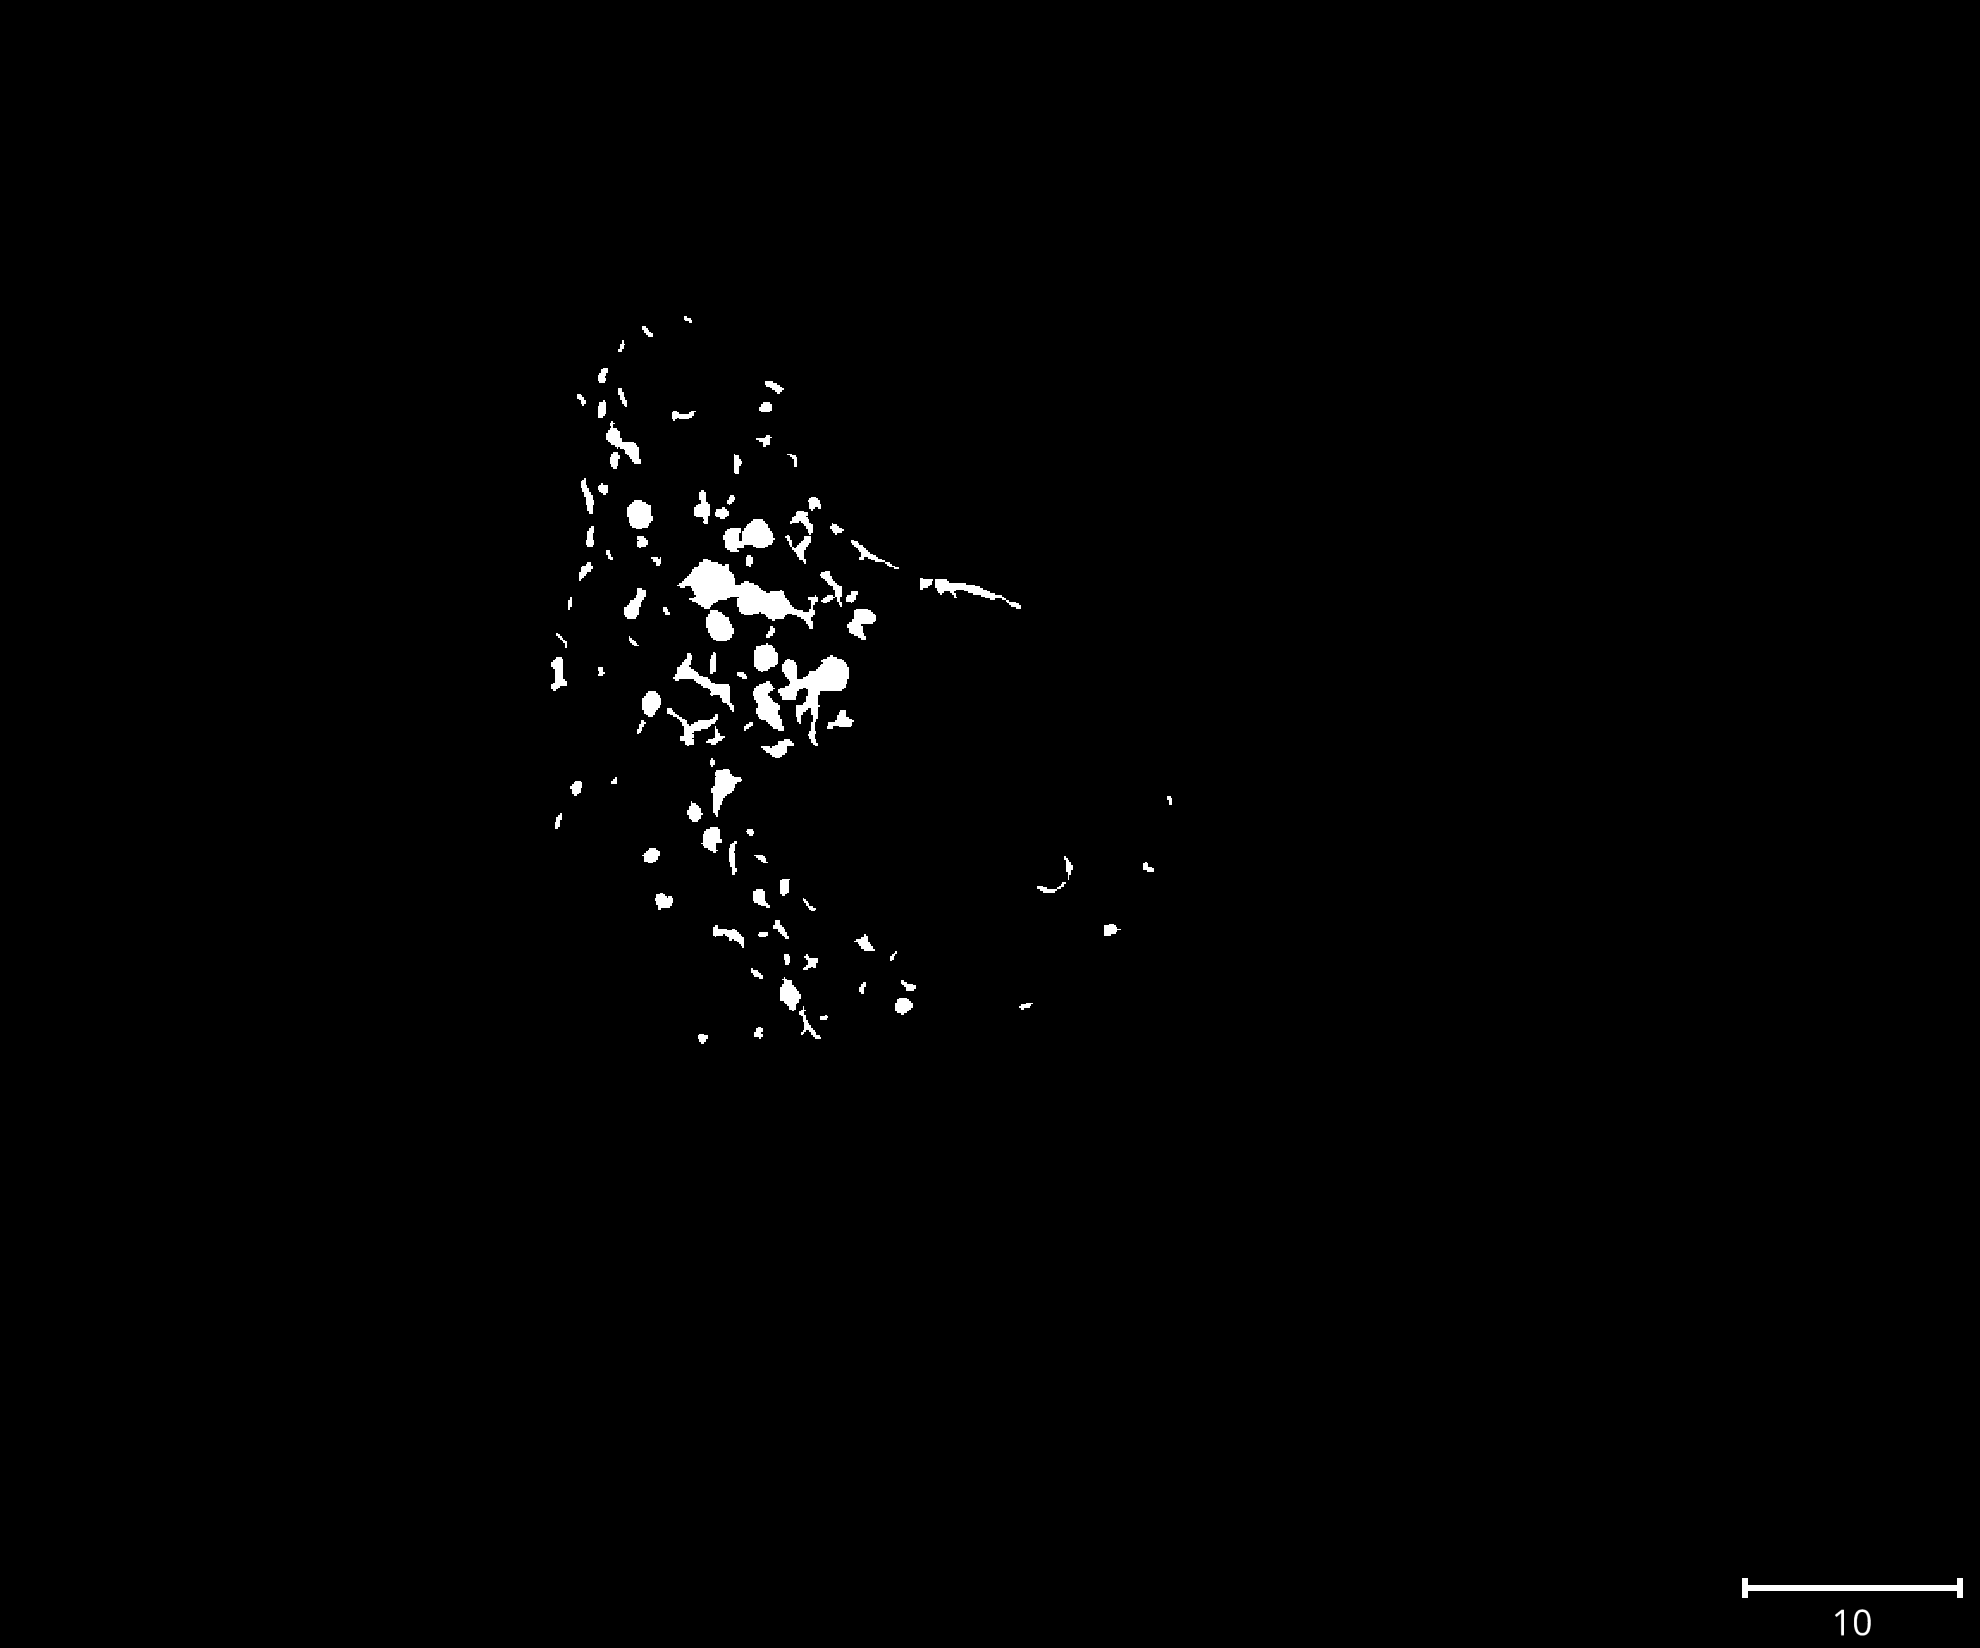

In [21]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

-----------------
## make function json to add to `all_functions.json`
### infer_lyso 

In [31]:
from infer_subc.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_lyso =  {
        "name": "infer lyso  (fixed parameters)",
        "python::module": "infer_subc.organelles",
        "python::function": "fixed_infer_lyso",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_lyso",_fixed_infer_lyso)

function fixed_infer_lyso is already in all_functions.json


0

In [32]:

_infer_lyso =  {
        "name": "infer lyso",
        "python::module": "infer_subc.organelles",
        "python::function": "infer_lyso",
        "parameters": {
                "median_sz": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "dot_scale_1": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_cut_1": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_scale_2": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_cut_2": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_scale_3": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_cut_3": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "min_hole_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 30,
                        "min": 0,
                        "widget_type": "slider"
                },    
                "max_hole_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 40,
                        "min": 4,
                        "widget_type": "slider"
                },           
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_lyso", _infer_lyso, overwrite=True )



function infer_lyso is already in all_functions.json
overwriting  infer_lyso


1

## a couple helper function

Wrappers for spot and filiment filters

In [33]:

def _lyso_spot_filter(in_img: np.ndarray) -> np.ndarray:
    """ spot filter helper function for lyso """
    dot_scale_1 = 5
    dot_cut_1 = 0.09
    dot_scale_2 = 2.5
    dot_cut_2 = 0.07
    dot_scale_3 = 1
    dot_cut_3 = 0.01
    s2_param = [[dot_scale_1, dot_cut_1], [dot_scale_2, dot_cut_2], [dot_scale_3, dot_cut_3]]
    return dot_2d_slice_by_slice_wrapper(in_img, s2_param)

# def _lyso_filiment_filter(in_img: np.ndarray) -> np.ndarray:
#     """ spot filter helper function for lyso  (DEPRICATED)"""
#     f2_param = [[filament_scale, filament_cut]]
#     # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
#     return filament_2d_wrapper(in_img, f2_param)



In [34]:
_lyso_spot_filter =  {
        "name": "lyso spot filter",
        "python::module": "infer_subc.organelles",
        "python::function": "lyso_spot_filter",
        "parameters": None
        }

add_function_spec_to_widget_json("lyso_spot_filter",_lyso_spot_filter, overwrite=True)

function lyso_spot_filter is already in all_functions.json
overwriting  lyso_spot_filter


1

In [35]:
_lyso_filiment_filter =  {
        "name": "lyso filiment filter",
        "python::module": "infer_subc.organelles",
        "python::function": "lyso_filiment_filter",
        "parameters": None
        }

add_function_spec_to_widget_json("lyso_filiment_filter",_lyso_filiment_filter)

function lyso_filiment_filter is already in all_functions.json


0

In [36]:
_logical_or =  {
        "name": "logical or",
        "python::module": "numpy",
        "python::function": "logical_or",
        "parameters": None
        }

add_function_spec_to_widget_json("logical_or",_logical_or)

function logical_or is already in all_functions.json


0

In [37]:
from infer_subc.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_nuclei =  {
        "name": "infer nuclei  (fixed parameters)",
        "python::module": "infer_subc.organelles",
        "python::function": "fixed_infer_nuclei",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_nuclei",_fixed_infer_nuclei)

function fixed_infer_nuclei is already in all_functions.json


0

In [38]:


    # NU_labels = label(nuclei_object)

_label =  {
        "name": "label objects",
        "python::module": "skimage.measure",
        "python::function": "label",
        "parameters": None
        }
# json.dumps({"label":_label})
add_function_spec_to_widget_json("label",_label)        


function label is already in all_functions.json


0

## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [39]:
from infer_subc.constants import LYSO_CH
def make_infer_lyso_step_by_step_from_raw_dict():
    """
    Procedure to infer lyso from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_cellmask_fromaggr")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytoplasm")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = LYSO_CH) )
    parent.append(1)
    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(6)

    step_name.append("8")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.34 ))
    parent.append(7)


    step_name.append("9")
    function_name.append("lyso_spot_filter")
    category.append("core")
    parameter_values.append( None )
    parent.append(8)

    # step_name.append("10")
    # function_name.append("lyso_filiment_filter")
    # category.append("core")
    # parameter_values.append( None )
    # parent.append(8)
    step_name.append("10")
    function_name.append("filament_filter") 
    category.append("core")
    parameter_values.append( dict( filament_scale=1., filament_cut=.15) )
    parent.append(8)

    step_name.append("11")
    function_name.append("logical_or")
    category.append("core")
    parameter_values.append( None )
    parent.append([9,10])

    step_name.append("12")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=25**2, fill_2d=True))
    parent.append(11)

    step_name.append("13")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([12,4])

    step_name.append("14")
    function_name.append("size_filter_linear_size")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 3**2  ))
    parent.append(13)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict

In [40]:
from infer_subc.organelles_config.helper import write_workflow_json

infer_lyso_stepbystep_from_raw_dict = make_infer_lyso_step_by_step_from_raw_dict()

write_workflow_json("conf_1.4.lyso_stepbystep_from_raw", infer_lyso_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc/infer_subc/organelles_config/conf_1.4.lyso_stepbystep_from_raw.json')

In [41]:
viewer.close()

: 